<a href="https://colab.research.google.com/github/umar052001/Deep-Learning-with-Tensorflow/blob/master/05_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transefer Learning with tensorflow: Fine Tuning



## Creating helper functions
In previous notebook we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, we created a script with all of them and now import it.

In [1]:
!wget https://raw.githubusercontent.com/umar052001/Deep-Learning-with-Tensorflow/master/helperFunctions.py

--2022-09-08 20:36:04--  https://raw.githubusercontent.com/umar052001/Deep-Learning-with-Tensorflow/master/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10512 (10K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  10.27K  --.-KB/s    in 0.004s  

2022-09-08 20:36:04 (2.37 MB/s) - ‘helperFunctions.py’ saved [10512/10512]



In [2]:
from helperFunctions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data
This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem.

In [3]:
# Get 10% of data from food101 dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-09-08 20:36:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   135MB/s    in 1.2s    

2022-09-08 20:36:08 (135 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [5]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.34158157e+02 1.34158157e+02 1.44158157e+02]
   [1.34142868e+02 1.36928574e+02 1.46000000e+02]
   [1.31571426e+02 1.36214279e+02 1.47000000e+02]
   ...
   [1.63086914e+02 1.30505203e+02 1.43367523e+02]
   [1.58025558e+02 1.27311317e+02 1.45382767e+02]
   [1.59173447e+02 1.37372513e+02 1.57372467e+02]]

  [[1.30734695e+02 1.32525513e+02 1.41928574e+02]
   [1.18122444e+02 1.21984688e+02 1.30984695e+02]
   [1.23255104e+02 1.30086731e+02 1.40142853e+02]
   ...
   [1.71168350e+02 1.38556061e+02 1.49112244e+02]
   [1.71714279e+02 1.37862244e+02 1.54005127e+02]
   [1.66107132e+02 1.36107193e+02 1.54178619e+02]]

  [[1.22872452e+02 1.26591835e+02 1.35591827e+02]
   [1.21561226e+02 1.28346939e+02 1.36846939e+02]
   [1.22433678e+02 1.31051010e+02 1.40816330e+02]
   ...
   [1.69827332e+02 1.35776215e+02 1.42516037e+02]
   [1.82061249e+02 1.39801041e+02 1.51387772e+02]
   [2.07766037e+02 1.64480331e+02 1.78051758e+02]]

  ...

  [[9.66581650e+01 6.36428566e+01 7.02908554e+01]
   [8

## Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs in sequential order.

But the functional api gives us more flexibility with our models.

In [10]:
# 1. Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (don't want to update the underlying pre-trained patterns)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs but you don't have to do that with EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) 

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pool 2d: {x.shape}")

# 7. Create the activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and saving history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing through base model: (None, 7, 7, 1280)
Shape after global average pool 2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220908-203618
Epoch 1/5
24/24 [==============================] - 37s 436ms/step - loss: 1.9561 - accuracy: 0.4000 - val_loss: 1.3828 - val_accuracy: 0.6948
Epoch 2/5
24/24 [==============================] - 10s 426ms/step - loss: 1.1744 - accuracy: 0.7427 - val_loss: 0.9351 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 13s 523ms/step - loss: 0.8441 - accuracy: 0.8107 - val_loss: 0.7524 - val_accuracy: 0.8168
Epoch 4/5
24/24 [==============================] - 11s 444ms/step - loss: 0.6878 - accuracy: 0.8413 - val_loss: 0.6626 - val_accuracy: 0.8324
Epoch 5/5
24/24 [==============================] - 8s 336ms/step - loss: 0.5922 - accuracy: 0.8640 - val_loss: 0.6093 - val_accuracy: 0.8408


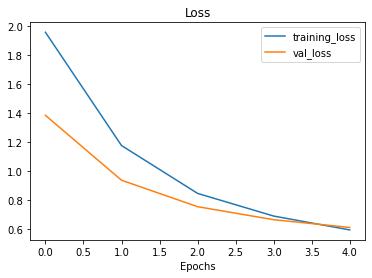

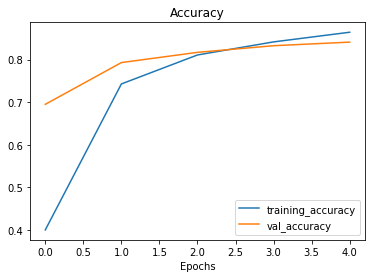

In [11]:
plot_loss_curves(history_0)

In [12]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 101ms/step - loss: 0.6093 - accuracy: 0.8408


[0.6092508435249329, 0.8407999873161316]

In [13]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Get a feature vector from trained model
Let's demonstrate the global average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape
(None, 7,7,1280)...

But when it passes through it turns into (None, 1280).

Let's use a similar shape tensor of (1, 4, 4 3) and then pass it through GlobalAveragePooling2D.

In [16]:
# Define input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Passing the tensor through global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape
print(f"Shape of 2D global average pooled tensor:\n{global_average_pooled_tensor.shape}\n")
print(f"Shape of random tensor:\n{input_tensor.shape}\n")


Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of 2D global average pooled tensor:
(1, 3)

Shape of random tensor:
(1, 4, 4, 3)



In [17]:
# Let's replicate the golbal pooling layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with 10% of our data but how does it go with 1% of our data. How about we set up some experiments.

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine tuning transfer learning with 10% of the training data with data augmentation.
4. `model_4` - use fine tuning transfer learning with 100% of the training data with data augmentation.

> Throughout the experiments we'll be using same test dataset. This ensures the consistency across evaluation metrics.

## Getting data with model_1

In [18]:
# Download and unzip - Preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-09-08 20:38:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   176MB/s    in 0.7s    

2022-09-08 20:38:21 (176 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [20]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [21]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation

To add data augmentation right into our models we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()` 

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping ,rotations, zoom etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1./255) for ResNet
], name="data_augmentation") 

## Visualize our data augmentation

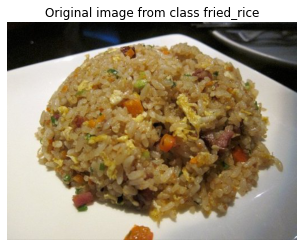

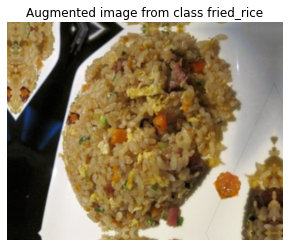

In [23]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original image from class {target_class}")
plt.axis(False)

# Now let's plot augmented random image
plt.figure()
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented image from class {target_class}")
plt.axis(False);

## Model_1: Feature extractioin transfer learning with 1% of data with augmentation


In [24]:
# Setup our input_shapes and base model, freezing the base model layers
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layers
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs after augmentation and don't train it
x = base_model(x, training=False)

# Pool the output features of the model
x =  layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer learning/1_percent_data_aug/20220908-203826
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.4062 - accuracy: 0.1000 - val_loss: 2.2519 - val_accuracy: 0.1464
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1357 - accuracy: 0.2857 - val_loss: 2.1265 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.0402 - accuracy: 0.3571 - val_loss: 2.0126 - val_accuracy: 0.3010
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8056 - accuracy: 0.4714 - val_loss: 1.9359 - val_accuracy: 0.3668
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6468 - accuracy: 0.6000 - val_loss: 1.8628 - val_accuracy: 0.4145


In [25]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [26]:
# Evaluate on full test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 76ms/step - loss: 1.8407 - accuracy: 0.4256


[1.8407230377197266, 0.42559999227523804]

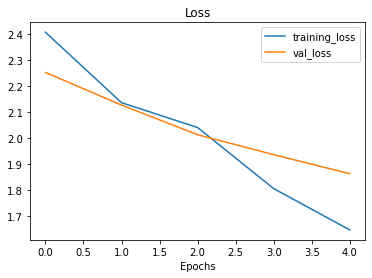

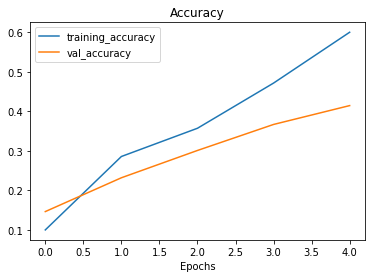

In [27]:
plot_loss_curves(history_1_percent)

## Model_2: feature extraction transfer learning model with 10% of data and data augmentation

In [28]:
# Get 10% of data...
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [29]:
# Setup data loaders 
import tensorflow as tf
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [31]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) for models like Resnet
], name="data_augmentation")

# Setup the input shape
input_shape=(224,224,3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs, training=True)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
output = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, output)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [32]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a model checkpoint callback
The ModelCheckPoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so that we can start where we left off

In [33]:
# Set checkpoint path
checkpointPath = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a model checkoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpointPath,
                                                         save_weights_only = True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

Fitting the model 2 and passing it ModelCheckPointCallback

In [34]:
initial_epochs = 5
history_10_percet_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug",),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220908-203913
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9991 - accuracy: 0.3440
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 25s 765ms/step - loss: 1.9991 - accuracy: 0.3440 - val_loss: 1.6290 - val_accuracy: 0.5609
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3497 - accuracy: 0.6760
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 18s 768ms/step - loss: 1.3497 - accuracy: 0.6760 - val_loss: 1.1881 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.7240
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 15s 616ms/step - loss: 1.0665 - accuracy: 0.7240 - val_loss: 1.0425 - val_accuracy: 0.7303
Epoc

In [35]:
# Comparing model_0 and model_2 result on whole test data
model_0.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.6093 - accuracy: 0.8408


[0.6092506051063538, 0.8407999873161316]

In [36]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 20s 252ms/step - loss: 0.8388 - accuracy: 0.7660


[0.8387944102287292, 0.765999972820282]

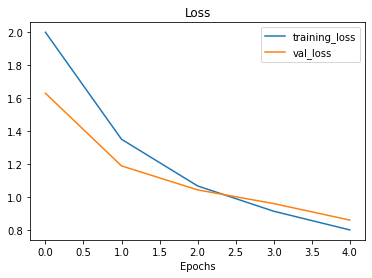

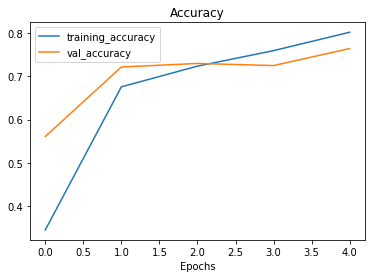

In [37]:
# Loss curves
plot_loss_curves(history_10_percet_data_aug)

### Loading in checkpointed weights

In [38]:
# Load in saved model weights and evaluate
model_2.load_weights(checkpointPath)

In [39]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 20s 246ms/step - loss: 0.8640 - accuracy: 0.7516


In [40]:
# Check to see both loaded and previous model results are close to each other
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([False, False])

## Model_3 : Fine tuning an existing model on 10% of the data

> Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of custom data.

In [41]:
# Layers in our loaded model
model_2.layers

In [42]:
# Are model_2 layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f716dad3f10> True
<keras.engine.sequential.Sequential object at 0x7f716dad3a10> True
<keras.engine.functional.Functional object at 0x7f716d664210> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f716dad3110> True
<keras.layers.core.dense.Dense object at 0x7f716d59ba50> True


In [43]:
# What layers were frozen
for i,  layer in enumerate(model_2.layers[2].layers):
  print(i, layer.trainable, layer.name)

0 False input_3
1 False rescaling_2
2 False normalization_2
3 False stem_conv_pad
4 False stem_conv
5 False stem_bn
6 False stem_activation
7 False block1a_dwconv
8 False block1a_bn
9 False block1a_activation
10 False block1a_se_squeeze
11 False block1a_se_reshape
12 False block1a_se_reduce
13 False block1a_se_expand
14 False block1a_se_excite
15 False block1a_project_conv
16 False block1a_project_bn
17 False block2a_expand_conv
18 False block2a_expand_bn
19 False block2a_expand_activation
20 False block2a_dwconv_pad
21 False block2a_dwconv
22 False block2a_bn
23 False block2a_activation
24 False block2a_se_squeeze
25 False block2a_se_reshape
26 False block2a_se_reduce
27 False block2a_se_expand
28 False block2a_se_excite
29 False block2a_project_conv
30 False block2a_project_bn
31 False block2b_expand_conv
32 False block2b_expand_bn
33 False block2b_expand_activation
34 False block2b_dwconv
35 False block2b_bn
36 False block2b_activation
37 False block2b_se_squeeze
38 False block2b_se

In [44]:
# How many trainable variables are there in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
# To begin fine tuning lets start with setting last 10 layers of our model.trainable = True
base_model.trainable = True
# Freeze all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile our model every time we make changes in our model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine tunining we typically want to lower the learning rate by 10x
                metrics = ["accuracy"])

In [46]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.trainable, layer.name)

0 False input_3
1 False rescaling_2
2 False normalization_2
3 False stem_conv_pad
4 False stem_conv
5 False stem_bn
6 False stem_activation
7 False block1a_dwconv
8 False block1a_bn
9 False block1a_activation
10 False block1a_se_squeeze
11 False block1a_se_reshape
12 False block1a_se_reduce
13 False block1a_se_expand
14 False block1a_se_excite
15 False block1a_project_conv
16 False block1a_project_bn
17 False block2a_expand_conv
18 False block2a_expand_bn
19 False block2a_expand_activation
20 False block2a_dwconv_pad
21 False block2a_dwconv
22 False block2a_bn
23 False block2a_activation
24 False block2a_se_squeeze
25 False block2a_se_reshape
26 False block2a_se_reduce
27 False block2a_se_expand
28 False block2a_se_excite
29 False block2a_project_conv
30 False block2a_project_bn
31 False block2b_expand_conv
32 False block2b_expand_bn
33 False block2b_expand_activation
34 False block2b_dwconv
35 False block2b_bn
36 False block2b_activation
37 False block2b_se_squeeze
38 False block2b_se

In [47]:
print(len(model_2.trainable_variables))

12


In [48]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percet_data_aug.epoch[-1],# start training from last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220908-204142
Epoch 5/10
24/24 [==============================] - 26s 590ms/step - loss: 0.6796 - accuracy: 0.8040 - val_loss: 0.7367 - val_accuracy: 0.7533
Epoch 6/10
24/24 [==============================] - 11s 432ms/step - loss: 0.5808 - accuracy: 0.8240 - val_loss: 0.7270 - val_accuracy: 0.7763
Epoch 7/10
24/24 [==============================] - 9s 361ms/step - loss: 0.4805 - accuracy: 0.8493 - val_loss: 0.6826 - val_accuracy: 0.7878
Epoch 8/10
24/24 [==============================] - 11s 439ms/step - loss: 0.4765 - accuracy: 0.8640 - val_loss: 0.6840 - val_accuracy: 0.7812
Epoch 9/10
24/24 [==============================] - 11s 433ms/step - loss: 0.4278 - accuracy: 0.8667 - val_loss: 0.6580 - val_accuracy: 0.7681
Epoch 10/10
24/24 [==============================] - 10s 392ms/step - loss: 0.3883 - accuracy: 0.8947 - val_loss: 0.6715 - val_accuracy: 0.7862


In [49]:
# Evaluate the fine tuned model 
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 19s 236ms/step - loss: 0.6332 - accuracy: 0.7876


In [50]:
results_10_percent_data_aug

[0.8387944102287292, 0.765999972820282]

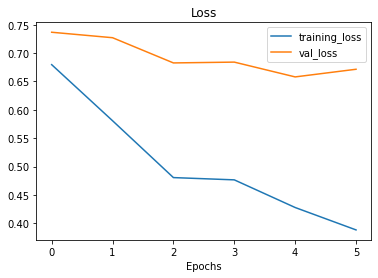

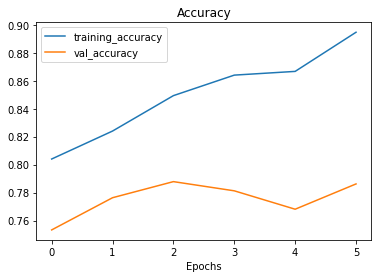

In [51]:
# Check out the loss curves of our fined tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [52]:
# Let's create a function for plotting loss curves to compare before and after fine tuning or comparing histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares tensorflow 2 history objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")

  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")

  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

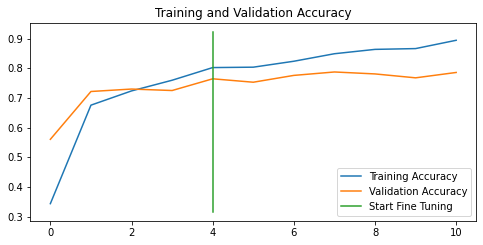

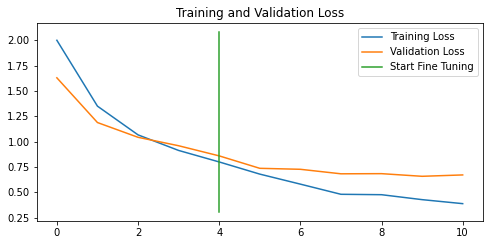

In [53]:
compare_histories(history_10_percet_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model_4: Fine tune existing model on all of the data

In [55]:
# Download and unzip 10 classes food 101 datset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-09-08 20:44:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  50.8MB/s    in 6.3s    

2022-09-08 20:44:17 (79.2 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [59]:
# setup train and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [60]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [61]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [65]:
train_data_10_classes_full.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

To train a fine-tuning model we need to revert model_2 back to it's feature extraction weights.

In [66]:
# Load weights from checkpoints so we can fine tune
# from same stage 10 percent model was fine tuned
model_2.load_weights(checkpointPath)

In [67]:
model_2.evaluate(test_data)

79/79 [==============================] - 17s 209ms/step - loss: 0.8425 - accuracy: 0.7716


[0.8425078392028809, 0.7716000080108643]

In [68]:
results_fine_tune_10_percent

[0.633224606513977, 0.7875999808311462]

In [69]:
results_10_percent_data_aug

[0.8387944102287292, 0.765999972820282]

All we've done is:
1. Trained a feature extraction transfer learning model for 5 epochson 10 % of data with data_augmentation (model_2) and we saved the model's weight using model checkpoint callback
2. Fine tuned the same model on same 10% of the data for a further 5 epochs with the last 10 layers unfrozen(model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as model_2 except this time we're using all of the data.

In [70]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [72]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [73]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [78]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percet_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="fine_tuned_10_classes")])

Saving TensorBoard log files to: transfer_learning/fine_tuned_10_classes/20220908-212721
Epoch 5/10
235/235 [==============================] - 50s 204ms/step - loss: 0.5998 - accuracy: 0.8045 - val_loss: 0.5028 - val_accuracy: 0.8240
Epoch 6/10
235/235 [==============================] - 48s 201ms/step - loss: 0.5326 - accuracy: 0.8288 - val_loss: 0.4164 - val_accuracy: 0.8635
Epoch 7/10
235/235 [==============================] - 43s 183ms/step - loss: 0.4871 - accuracy: 0.8453 - val_loss: 0.3861 - val_accuracy: 0.8766
Epoch 8/10
235/235 [==============================] - 35s 148ms/step - loss: 0.4512 - accuracy: 0.8539 - val_loss: 0.4299 - val_accuracy: 0.8553
Epoch 9/10
235/235 [==============================] - 38s 160ms/step - loss: 0.4232 - accuracy: 0.8648 - val_loss: 0.4176 - val_accuracy: 0.8503
Epoch 10/10
235/235 [==============================] - 37s 155ms/step - loss: 0.3935 - accuracy: 0.8739 - val_loss: 0.4083 - val_accuracy: 0.8651


In [79]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 12s 141ms/step - loss: 0.4062 - accuracy: 0.8696


[0.4062058627605438, 0.8695999979972839]

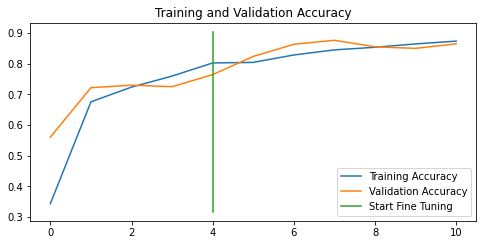

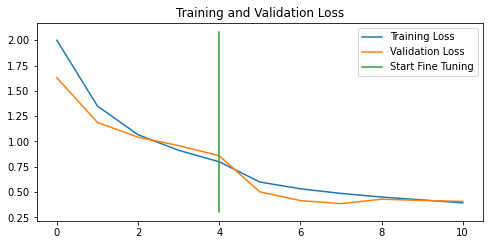

In [81]:
compare_histories(history_10_percet_data_aug,
                  history_fine_10_classes_full,
                  initial_epochs=5)

## Viewing our experiment data on Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning experiments with 10 food101 classes" \
  --description "A series of different transfer learning experiments with varying amount of data"\
  --one_shot # exits the uploader

My tensorboard experiments are available at https://tensorboard.dev/experiment/TVsLTnnuQ1OE58gyU5P9mw/

In [85]:
!tensorboard dev list

https://tensorboard.dev/experiment/TVsLTnnuQ1OE58gyU5P9mw/
	Name                 Transfer Learning experiments with 10 food101 classes
	Description          A series of different transfer learning experiments with varying amount of data
	Id                   TVsLTnnuQ1OE58gyU5P9mw
	Created              2022-09-08 21:41:40 (7 minutes ago)
	Updated              2022-09-08 21:41:45 (7 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              138
	Tensor bytes         0
	Binary object bytes  4323660
https://tensorboard.dev/experiment/FWgOPYwYT96QBHONzC92sw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different tf hub feature extraction model architechtures using 10% of the training data
	Id                   FWgOPYwYT96QBHONzC92sw
	Created              2022-09-07 00:46:37
	Updated              2022-09-07 00:46:46
	Runs                 10
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary ob